# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util

/home/jdowling/anaconda3/envs/book/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
today = datetime.datetime.now() #date.today()
tomorrow = today + datetime.timedelta(days = 1)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login()
conn = hopsworks.connection()
fs = project.get_feature_store() 

location_str = conn.get_secrets_api().get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
print(location_str)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works:443/p/5240
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.
{"country": "sweden", "city": "stockholm", "street": "stockholm-hornsgatan-108-gata"}


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

External IP not configured for the Istio ingress gateway, the Hopsworks client will be used for model inference instead
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5450603E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

/arrow/cpp/src/arrow/status.cc:137: DoAction result was not fully consumed: Cancelled: Flight cancelled call, with message: CANCELLED. Detail: Cancelled


Finished: Reading data from Hopsworks, using ArrowFlight (0.76s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-03-28 00:00:00+00:00,10.35,0.0,14.400000,126.869987,stockholm
1,2024-03-29 00:00:00+00:00,12.75,0.0,22.264771,247.166306,stockholm
2,2024-03-30 00:00:00+00:00,11.85,0.0,14.264361,259.824554,stockholm
3,2024-03-31 00:00:00+00:00,4.40,1.3,15.281989,43.090858,stockholm
4,2024-04-01 00:00:00+00:00,3.75,0.0,17.339897,41.633450,stockholm
5,2024-04-02 00:00:00+00:00,0.65,0.0,27.511160,6.008918,stockholm
6,2024-04-03 00:00:00+00:00,-2.10,0.0,24.288662,348.023895,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-03-28 00:00:00+00:00,10.35,0.0,14.400000,126.869987,stockholm,36.512714
1,2024-03-29 00:00:00+00:00,12.75,0.0,22.264771,247.166306,stockholm,14.207741
2,2024-03-30 00:00:00+00:00,11.85,0.0,14.264361,259.824554,stockholm,27.318539
3,2024-03-31 00:00:00+00:00,4.40,1.3,15.281989,43.090858,stockholm,42.660854
4,2024-04-01 00:00:00+00:00,3.75,0.0,17.339897,41.633450,stockholm,19.433962
5,2024-04-02 00:00:00+00:00,0.65,0.0,27.511160,6.008918,stockholm,18.087872
6,2024-04-03 00:00:00+00:00,-2.10,0.0,24.288662,348.023895,stockholm,21.283571


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         7 non-null      datetime64[ns, UTC]
 1   temperature_2m_mean          7 non-null      float32            
 2   precipitation_sum            7 non-null      float32            
 3   wind_speed_10m_max           7 non-null      float32            
 4   wind_direction_10m_dominant  7 non-null      float32            
 5   city                         7 non-null      object             
 6   predicted_pm25               7 non-null      float32            
dtypes: datetime64[ns, UTC](1), float32(5), object(1)
memory usage: 380.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-03-28 00:00:00+00:00,10.35,0.0,14.400000,126.869987,stockholm,36.512714,stockholm-hornsgatan-108-gata,sweden,1
1,2024-03-29 00:00:00+00:00,12.75,0.0,22.264771,247.166306,stockholm,14.207741,stockholm-hornsgatan-108-gata,sweden,2
2,2024-03-30 00:00:00+00:00,11.85,0.0,14.264361,259.824554,stockholm,27.318539,stockholm-hornsgatan-108-gata,sweden,3
3,2024-03-31 00:00:00+00:00,4.40,1.3,15.281989,43.090858,stockholm,42.660854,stockholm-hornsgatan-108-gata,sweden,4
4,2024-04-01 00:00:00+00:00,3.75,0.0,17.339897,41.633450,stockholm,19.433962,stockholm-hornsgatan-108-gata,sweden,5
5,2024-04-02 00:00:00+00:00,0.65,0.0,27.511160,6.008918,stockholm,18.087872,stockholm-hornsgatan-108-gata,sweden,6
6,2024-04-03 00:00:00+00:00,-2.10,0.0,24.288662,348.023895,stockholm,21.283571,stockholm-hornsgatan-108-gata,sweden,7


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         7 non-null      datetime64[ns, UTC]
 1   temperature_2m_mean          7 non-null      float32            
 2   precipitation_sum            7 non-null      float32            
 3   wind_speed_10m_max           7 non-null      float32            
 4   wind_direction_10m_dominant  7 non-null      float32            
 5   city                         7 non-null      object             
 6   predicted_pm25               7 non-null      float32            
 7   street                       7 non-null      object             
 8   country                      7 non-null      object             
 9   days_before_forecast_day     7 non-null      int64              
dtypes: datetime64[ns, UTC](1), float32(5), int64(1), objec

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

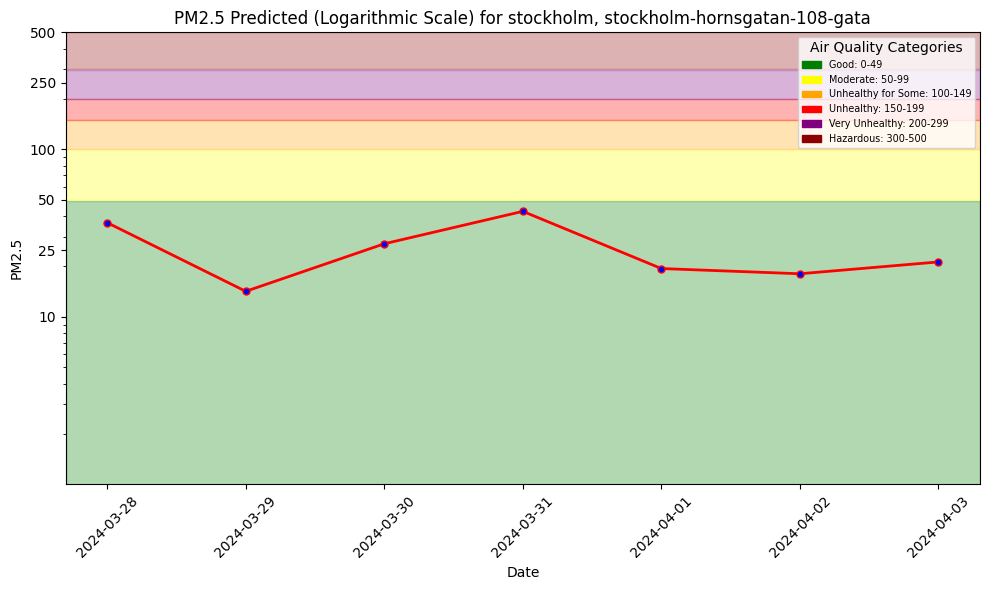

In [12]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_monitoring',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['country','street','date', 'days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█████████████████████████████████████████████████████████████████████████████████| Rows 7/7 | Elapsed Time: 00:03 | Remaining Time: 00:00


Launching job: aq_monitoring_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/5240/jobs/named/aq_monitoring_1_offline_fg_materialization/executions


In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

In [ ]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---